In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

from keras import regularizers, optimizers
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.models import Sequential,load_model
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

from tensorflow.keras.callbacks import History,EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError as rmse

from scripts_ import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("modelling_data.csv")


countries,scaler  = general_data_prep(data,shift=14)

cols_not = ["total_deaths_per_million",
            'new_tests_per_thousand', 'positive_rate','tests_per_case',"reproduction_rate","total_cases_per_million"]

del(countries["germany"])

X_train,X_test,y_train,y_test = prep_sequences(countries,cols_not,"new_deaths_per_million")

Index(['total_cases_per_million', 'new_cases_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'reproduction_rate', 'hosp_patients_per_million',
       'new_tests_per_thousand', 'positive_rate', 'tests_per_case',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'hospital_beds_per_thousand', 'life_expectancy',
       'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
       'H7_Vaccination policy', 'H8_Protection of elderly people',
       'mobility_recreation', 'mobility_grocery', 'mobility_parks',
       'mobility_t

In [4]:
model = Sequential()

model.add(LSTM(256,input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(Activation("relu"))
model.add(Dropout(0))

model.add(LSTM(128))
model.add(Activation("relu"))
model.add(Dropout(0))


model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0))


model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0))



model.add(Dense(1,activation="linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 256)           294912    
_________________________________________________________________
activation (Activation)      (None, 90, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [5]:
history = History()
Adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
early = EarlyStopping(monitor="val_loss",patience=5)
model.compile(loss="mse",optimizer=Adam,metrics=[rmse()])

In [6]:
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=20,batch_size=64,callbacks=[history])

Epoch 1/20
36/36 [==============================] - 15s 333ms/step - loss: 0.0083 - root_mean_squared_error: 0.0896 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 2/20
36/36 [==============================] - 11s 301ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 3/20
36/36 [==============================] - 11s 298ms/step - loss: 6.6760e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 4/20
36/36 [==============================] - 11s 300ms/step - loss: 4.9928e-04 - root_mean_squared_error: 0.0223 - val_loss: 3.1228e-04 - val_root_mean_squared_error: 0.0177
Epoch 5/20
36/36 [==============================] - 11s 299ms/step - loss: 2.5784e-04 - root_mean_squared_error: 0.0160 - val_loss: 2.6033e-04 - val_root_mean_squared_error: 0.0161
Epoch 6/20
36/36 [==============================] - 11s 301ms/step - loss: 1.8561e-04 - root_mean_squared_error: 0.

In [10]:
model.save("deaths_model.keras")

In [7]:
reverse_scaler = MinMaxScaler()
reverse_scaler.min_,reverse_scaler.scale_ = scaler.min_[4], scaler.scale_[4]

COUNTRY: belgium


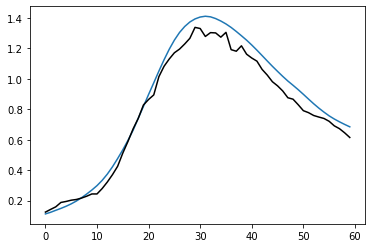

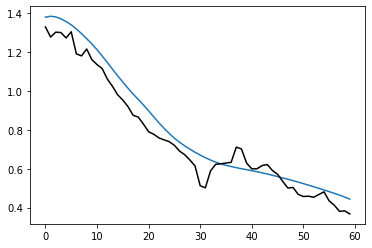

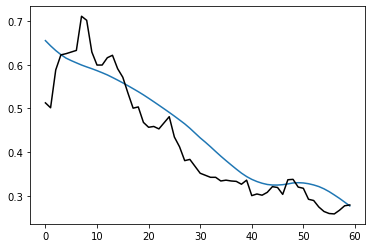

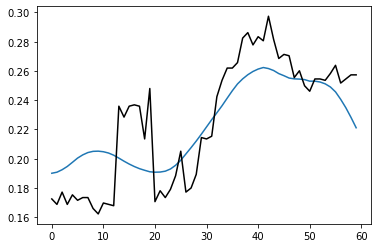

COUNTRY: france


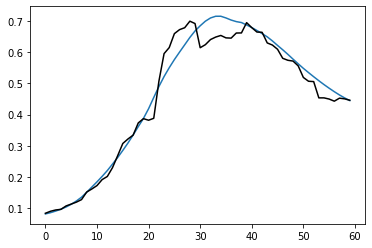

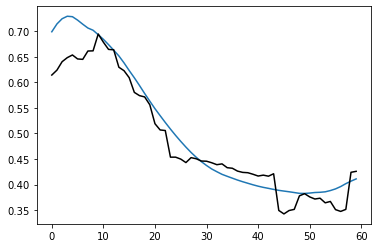

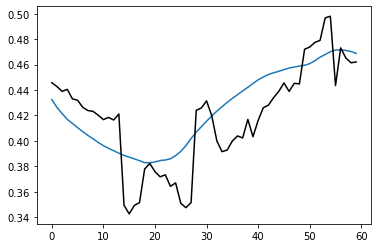

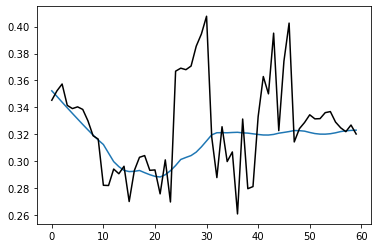

COUNTRY: israel


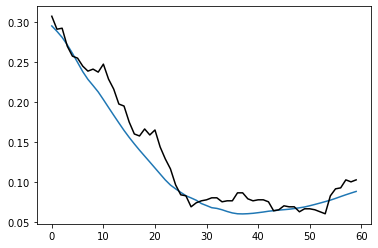

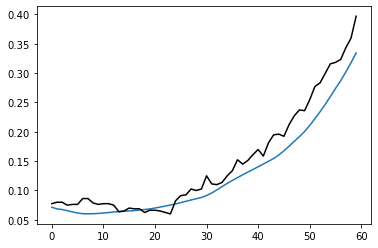

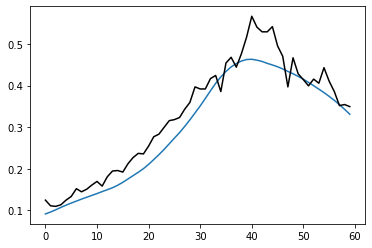

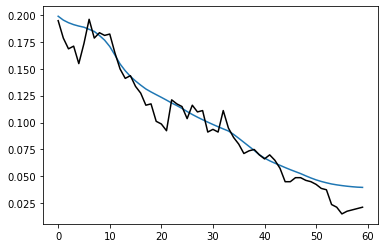

COUNTRY: italy


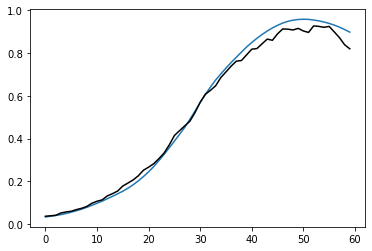

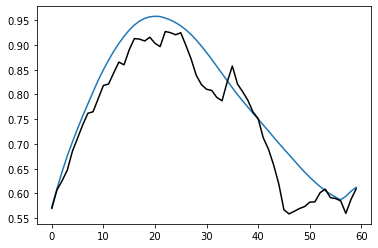

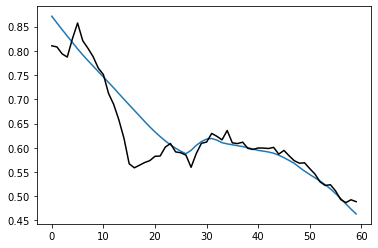

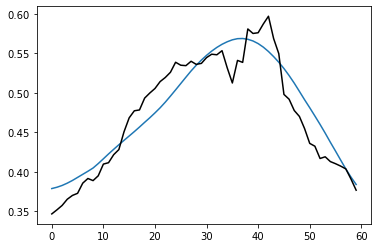

COUNTRY: sweden


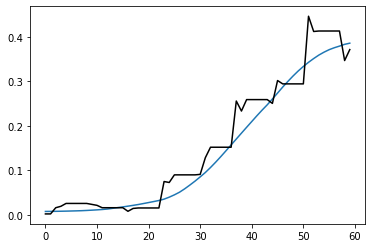

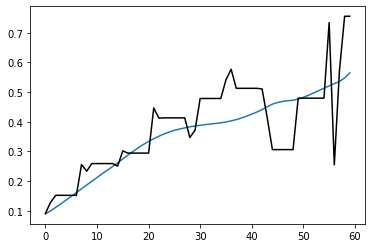

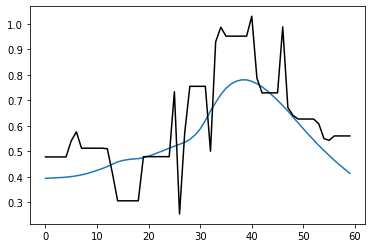

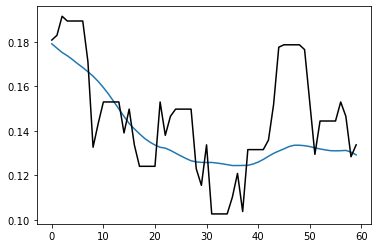

COUNTRY: poland


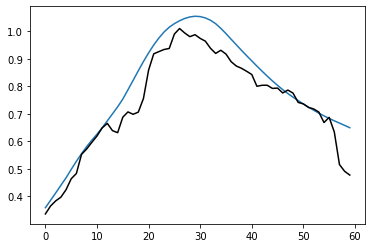

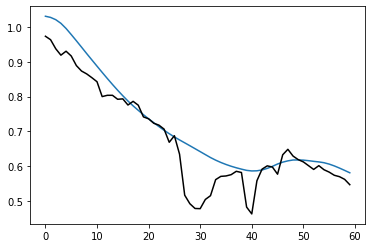

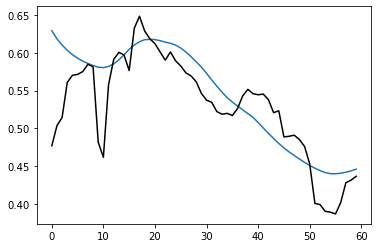

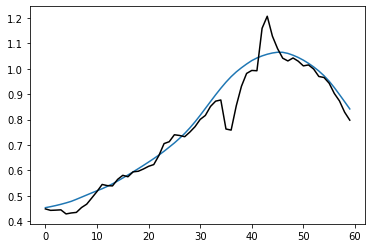

COUNTRY: uk


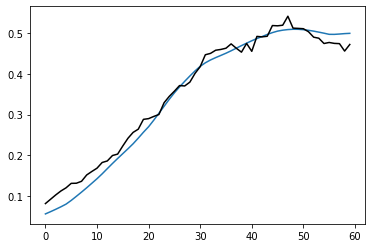

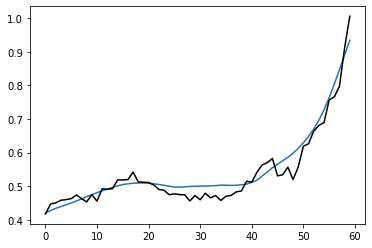

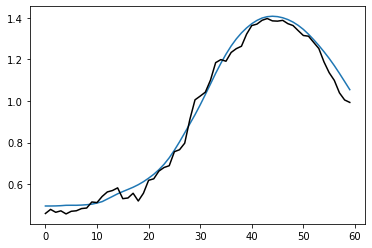

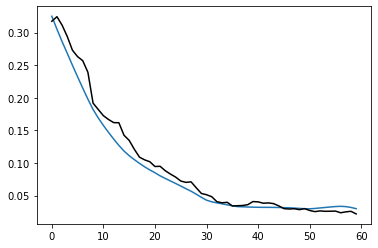

COUNTRY: austria


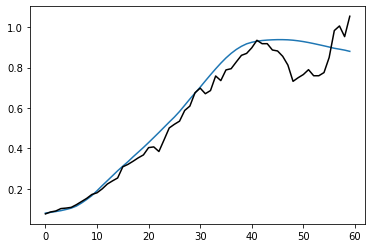

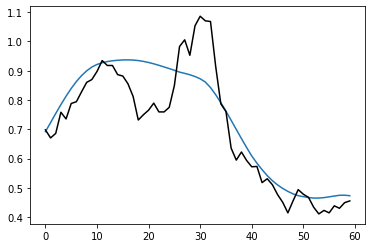

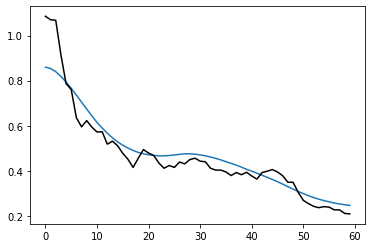

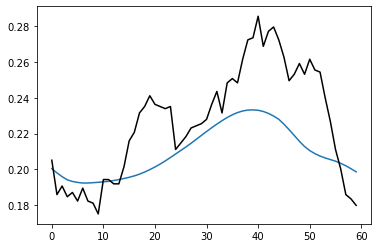

COUNTRY: netherlands


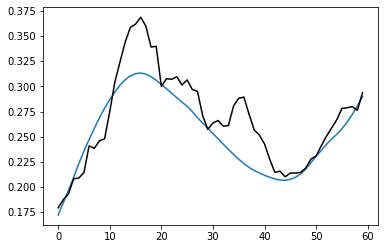

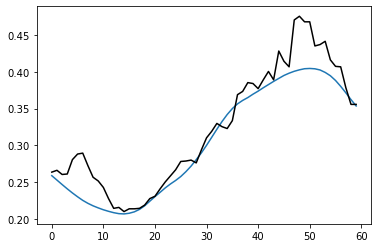

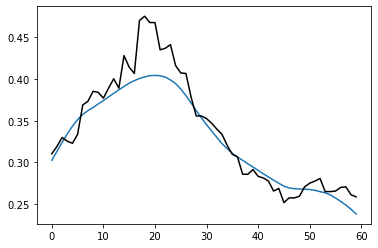

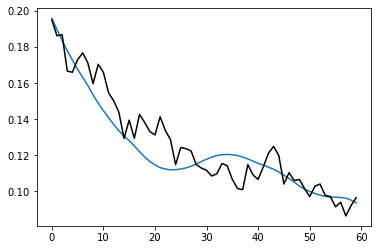

COUNTRY: spain


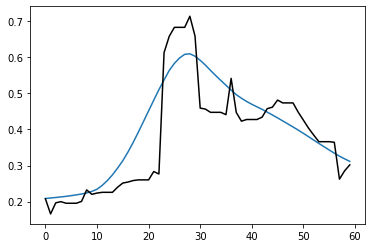

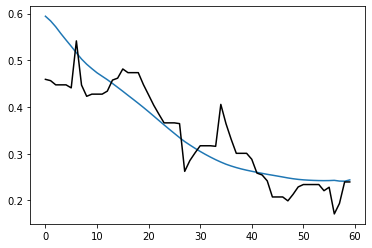

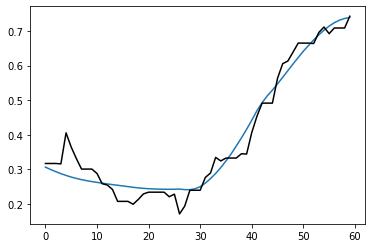

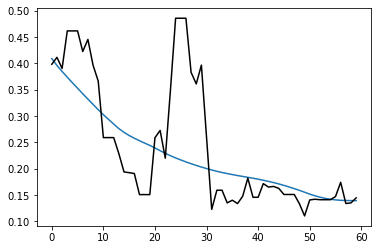

COUNTRY: portugal


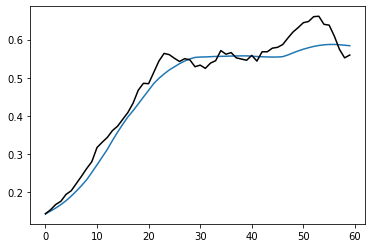

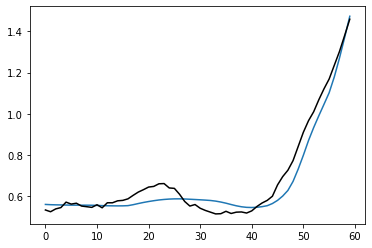

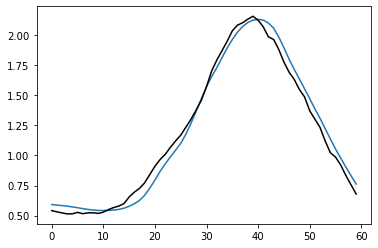

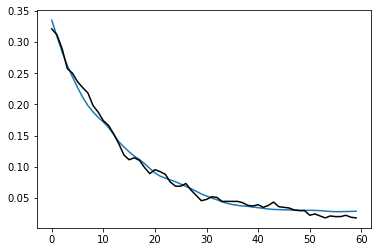

 Root mean squared error for set: 0.05193668861869474, R2 score 0.807200682853252


In [8]:
evaluate_set(countries,reverse_scaler,model,1,"new_deaths_per_million")

COUNTRY: poland


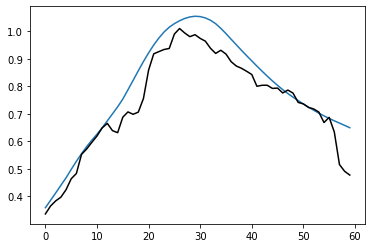

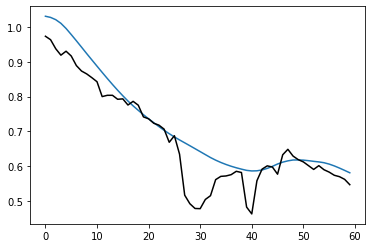

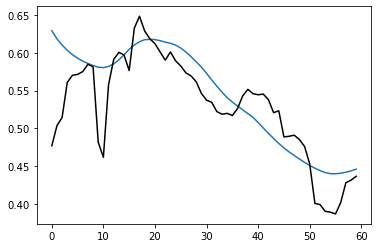

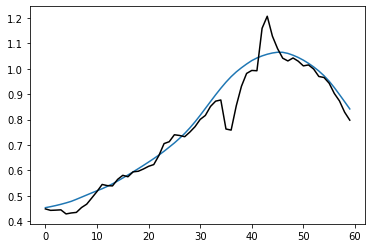

 Root mean squared error for set: 0.05798831320733565, R2 score 0.7940606916016055


In [9]:
poland = {
    "poland":countries["poland"]
}



evaluate_set(poland,reverse_scaler,model,1,target_col="new_deaths_per_million")